torch.Size([60000, 28, 28])
torch.Size([60000])


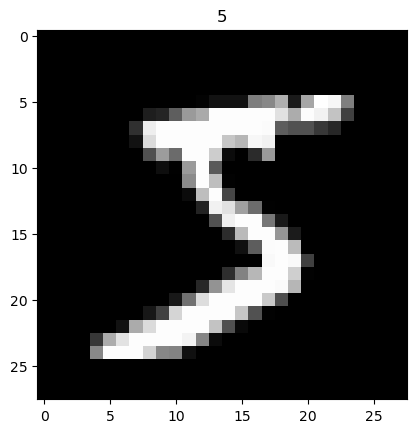

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.322834
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.236447
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.118064
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.793712
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.639150
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.522026
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.444431
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.304309
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.276492
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.224129
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.445756
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.395542
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.208383
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.061456
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.185824
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.252865
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.312695
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.558231
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.174176
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.231722
Train Epoch: 1 [12800/60000 (

In [11]:
"""Assignment_2_Part_2_RNN_MNIST_vp1.ipynb
Overall structure:

1) Set Pytorch metada
- seed
- tensorflow output
- whether to transfer to gpu (cuda)

2) Import data
- download data
- create data loaders with batchsie, transforms, scaling

3) Define Model architecture, loss and optimizer

4) Define Test and Training loop
    - Train:
        a. get next batch
        b. forward pass through model
        c. calculate loss
        d. backward pass from loss (calculates the gradient for each parameter)
        e. optimizer: performs weight updates

5) Perform Training over multiple epochs:
    Each epoch:
    - call train loop
    - call test loop

# Step 1: Pytorch and Training Metadata
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os
from pathlib import Path
import matplotlib.pyplot as plt

batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 0.001
try_cuda = True
seed = 1000
logging_interval = 10 # how many batches to wait before logging
logging_dir = None

INPUT_SIZE = 28

# 1) setting up the logging

datetime_str = datetime.now().strftime('%b%d_%H-%M-%S')

if logging_dir is None:
    runs_dir = Path("./") / Path(f"runs/")
    runs_dir.mkdir(exist_ok = True)

    logging_dir = runs_dir / Path(f"{datetime_str}")

    logging_dir.mkdir(exist_ok = True)
    logging_dir = str(logging_dir.absolute())

writer = SummaryWriter(log_dir=logging_dir)

#deciding whether to send to the cpu or not if available
if torch.cuda.is_available() and try_cuda:
    cuda = True
    torch.cuda.manual_seed(seed)
else:
    cuda = False
    torch.manual_seed(seed)
"""# Step 2: Data Setup"""

# Setting up data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

# plot one example
print(train_dataset.data.size())     # (60000, 28, 28)
print(train_dataset.targets.size())   # (60000)
plt.imshow(train_dataset.data[0].numpy(), cmap='gray')
plt.title('%i' % train_dataset.targets[0])
plt.show()

"""# Step 3: Creating the Model"""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.rnn = nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=64,     # number of hidden units
            num_layers=2,       # number of layers
            batch_first=True,
        )
        self.out = nn.Linear(64, 10)  # 10 classes for MNIST

    def forward(self, x):
        r_out, hidden = self.rnn(x, None)
        out = self.out(r_out[:, -1, :])
        return out

model = Net()

if cuda:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)

"""# Step 4: Train/Test"""

def train(epoch):
    model.train()
    criterion = nn.CrossEntropyLoss()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()

        data = data.view(-1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % logging_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            writer.add_scalar('training_loss', loss.item(), epoch * len(train_loader) + batch_idx)

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss(size_average=False)
    with torch.no_grad():
        for data, target in test_loader:
            if cuda:
                data, target = data.cuda(), target.cuda()
            data = data.view(-1, 28, 28)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    writer.add_scalar('test_loss', test_loss, epoch)
    writer.add_scalar('test_accuracy', 100. * correct / len(test_loader.dataset), epoch)

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    print('finish epoch',epoch)

writer.close()


In [ ]:
"""Assignment_2_Part_2_RNN_MNIST_vp1.ipynb
Overall structure:

1) Set Pytorch metada
- seed
- tensorflow output
- whether to transfer to gpu (cuda)

2) Import data
- download data
- create data loaders with batchsie, transforms, scaling

3) Define Model architecture, loss and optimizer

4) Define Test and Training loop
    - Train:
        a. get next batch
        b. forward pass through model
        c. calculate loss
        d. backward pass from loss (calculates the gradient for each parameter)
        e. optimizer: performs weight updates

5) Perform Training over multiple epochs:
    Each epoch:
    - call train loop
    - call test loop

# Step 1: Pytorch and Training Metadata
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os
from pathlib import Path
import matplotlib.pyplot as plt

batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 0.001
try_cuda = True
seed = 1000
logging_interval = 10 # how many batches to wait before logging
logging_dir = None

INPUT_SIZE = 28

# 1) setting up the logging

datetime_str = datetime.now().strftime('%b%d_%H-%M-%S')

if logging_dir is None:
    runs_dir = Path("./") / Path(f"runs/")
    runs_dir.mkdir(exist_ok = True)

    logging_dir = runs_dir / Path(f"{datetime_str}")

    logging_dir.mkdir(exist_ok = True)
    logging_dir = str(logging_dir.absolute())

writer = SummaryWriter(log_dir=logging_dir)

#deciding whether to send to the cpu or not if available
if torch.cuda.is_available() and try_cuda:
    cuda = True
    torch.cuda.manual_seed(seed)
else:
    cuda = False
    torch.manual_seed(seed)
"""# Step 2: Data Setup"""

# Setting up data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

# plot one example
print(train_dataset.data.size())     # (60000, 28, 28)
print(train_dataset.targets.size())   # (60000)
plt.imshow(train_dataset.data[0].numpy(), cmap='gray')
plt.title('%i' % train_dataset.targets[0])
plt.show()

"""# Step 3: Creating the Model"""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Using LSTM instead of RNN
        self.rnn = nn.LSTM(
            input_size=INPUT_SIZE,
            hidden_size=128,     # number of hidden units
            num_layers=1,       # number of layers
            batch_first=True,
        )
        self.out = nn.Linear(128, 10)  # 10 classes for MNIST

    def forward(self, x):
        # LSTM returns output, (h_n, c_n)
        r_out, (h_n, c_n) = self.rnn(x, None)
        out = self.out(r_out[:, -1, :])
        return out

model = Net()

if cuda:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)

"""# Step 4: Train/Test"""

def train(epoch):
    model.train()
    criterion = nn.CrossEntropyLoss()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()

        data = data.view(-1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % logging_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            writer.add_scalar('training_loss', loss.item(), epoch * len(train_loader) + batch_idx)

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss(size_average=False)
    with torch.no_grad():
        for data, target in test_loader:
            if cuda:
                data, target = data.cuda(), target.cuda()
            data = data.view(-1, 28, 28)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    writer.add_scalar('test_loss', test_loss, epoch)
    writer.add_scalar('test_accuracy', 100. * correct / len(test_loader.dataset), epoch)

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    print('finish epoch',epoch)

writer.close()


torch.Size([60000, 28, 28])
torch.Size([60000])


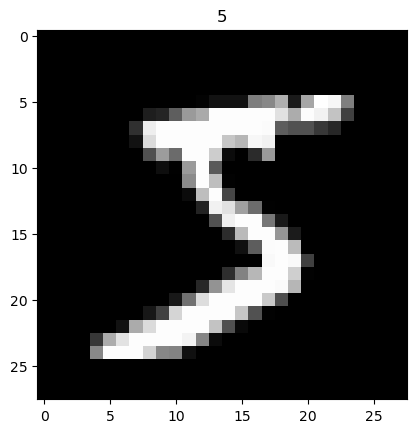

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.330496
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.247383
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.040808
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.785809
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.716329
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.383663
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.117331
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.883184
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.792121
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.882863
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.693981
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.558631
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.621032
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.643279
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.583692
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.359569
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.374760
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.137722
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.528172
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.242873
Train Epoch: 1 [12800/60000 (

In [8]:
"""Assignment_2_Part_2_RNN_MNIST_vp1.ipynb
Overall structure:

1) Set Pytorch metada
- seed
- tensorflow output
- whether to transfer to gpu (cuda)

2) Import data
- download data
- create data loaders with batchsie, transforms, scaling

3) Define Model architecture, loss and optimizer

4) Define Test and Training loop
    - Train:
        a. get next batch
        b. forward pass through model
        c. calculate loss
        d. backward pass from loss (calculates the gradient for each parameter)
        e. optimizer: performs weight updates

5) Perform Training over multiple epochs:
    Each epoch:
    - call train loop
    - call test loop

# Step 1: Pytorch and Training Metadata
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os
from pathlib import Path
import matplotlib.pyplot as plt

batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 0.001
try_cuda = True
seed = 1000
logging_interval = 10 # how many batches to wait before logging
logging_dir = None

INPUT_SIZE = 28

# 1) setting up the logging

datetime_str = datetime.now().strftime('%b%d_%H-%M-%S')

if logging_dir is None:
    runs_dir = Path("./") / Path(f"runs/")
    runs_dir.mkdir(exist_ok = True)

    logging_dir = runs_dir / Path(f"{datetime_str}")

    logging_dir.mkdir(exist_ok = True)
    logging_dir = str(logging_dir.absolute())

writer = SummaryWriter(log_dir=logging_dir)

#deciding whether to send to the cpu or not if available
if torch.cuda.is_available() and try_cuda:
    cuda = True
    torch.cuda.manual_seed(seed)
else:
    cuda = False
    torch.manual_seed(seed)
"""# Step 2: Data Setup"""

# Setting up data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

# plot one example
print(train_dataset.data.size())     # (60000, 28, 28)
print(train_dataset.targets.size())   # (60000)
plt.imshow(train_dataset.data[0].numpy(), cmap='gray')
plt.title('%i' % train_dataset.targets[0])
plt.show()

"""# Step 3: Creating the Model"""

"""# Step 3: Creating the Model"""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Using GRU instead of RNN
        self.rnn = nn.GRU(
            input_size=INPUT_SIZE,
            hidden_size=128,     # number of hidden units
            num_layers=2,       # number of layers
            batch_first=True,
        )
        self.out = nn.Linear(128, 10)  # 10 classes for MNIST

    def forward(self, x):
        # GRU returns output, h_n
        r_out, h_n = self.rnn(x, None)
        out = self.out(r_out[:, -1, :])
        return out

model = Net()

if cuda:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)

# ... [rest of the code remains unchanged]


"""# Step 4: Train/Test"""

def train(epoch):
    model.train()
    criterion = nn.CrossEntropyLoss()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()

        data = data.view(-1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % logging_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            writer.add_scalar('training_loss', loss.item(), epoch * len(train_loader) + batch_idx)

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss(size_average=False)
    with torch.no_grad():
        for data, target in test_loader:
            if cuda:
                data, target = data.cuda(), target.cuda()
            data = data.view(-1, 28, 28)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    writer.add_scalar('test_loss', test_loss, epoch)
    writer.add_scalar('test_accuracy', 100. * correct / len(test_loader.dataset), epoch)

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    print('finish epoch',epoch)

writer.close()


In [9]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [10]:
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 78749), started 0:22:02 ago. (Use '!kill 78749' to kill it.)